In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from itertools import product
import librosa
from pathlib import Path
import math
import pysptk

from models.utils import get_logits2biquads, get_transformed_lf_v2


logits2biquads = get_logits2biquads("coef")
# from models.utils import ismir2interspeech_ckpt

In [2]:
f1_folder = "tismir_tmp_audio/harm_and_noise/f1/"
m1_folder = "tismir_tmp_audio/harm_and_noise/m1/"
n_fft = 1024
hop_length = 256


def get_harm_noise_specs(folder: Path):
    get_specs = lambda it: np.concatenate(
        list(
            map(
                lambda x: np.abs(
                    librosa.stft(
                        librosa.load(x, sr=None)[0], n_fft=n_fft, hop_length=hop_length
                    )
                ),
                it,
            )
        ),
        axis=1,
    )
    return get_specs(folder.rglob("*harms.wav")), get_specs(folder.rglob("*noise.wav"))


f1_specs_dict = {x.stem: get_harm_noise_specs(x) for x in Path(f1_folder).iterdir()}
m1_specs_dict = {x.stem: get_harm_noise_specs(x) for x in Path(m1_folder).iterdir()}

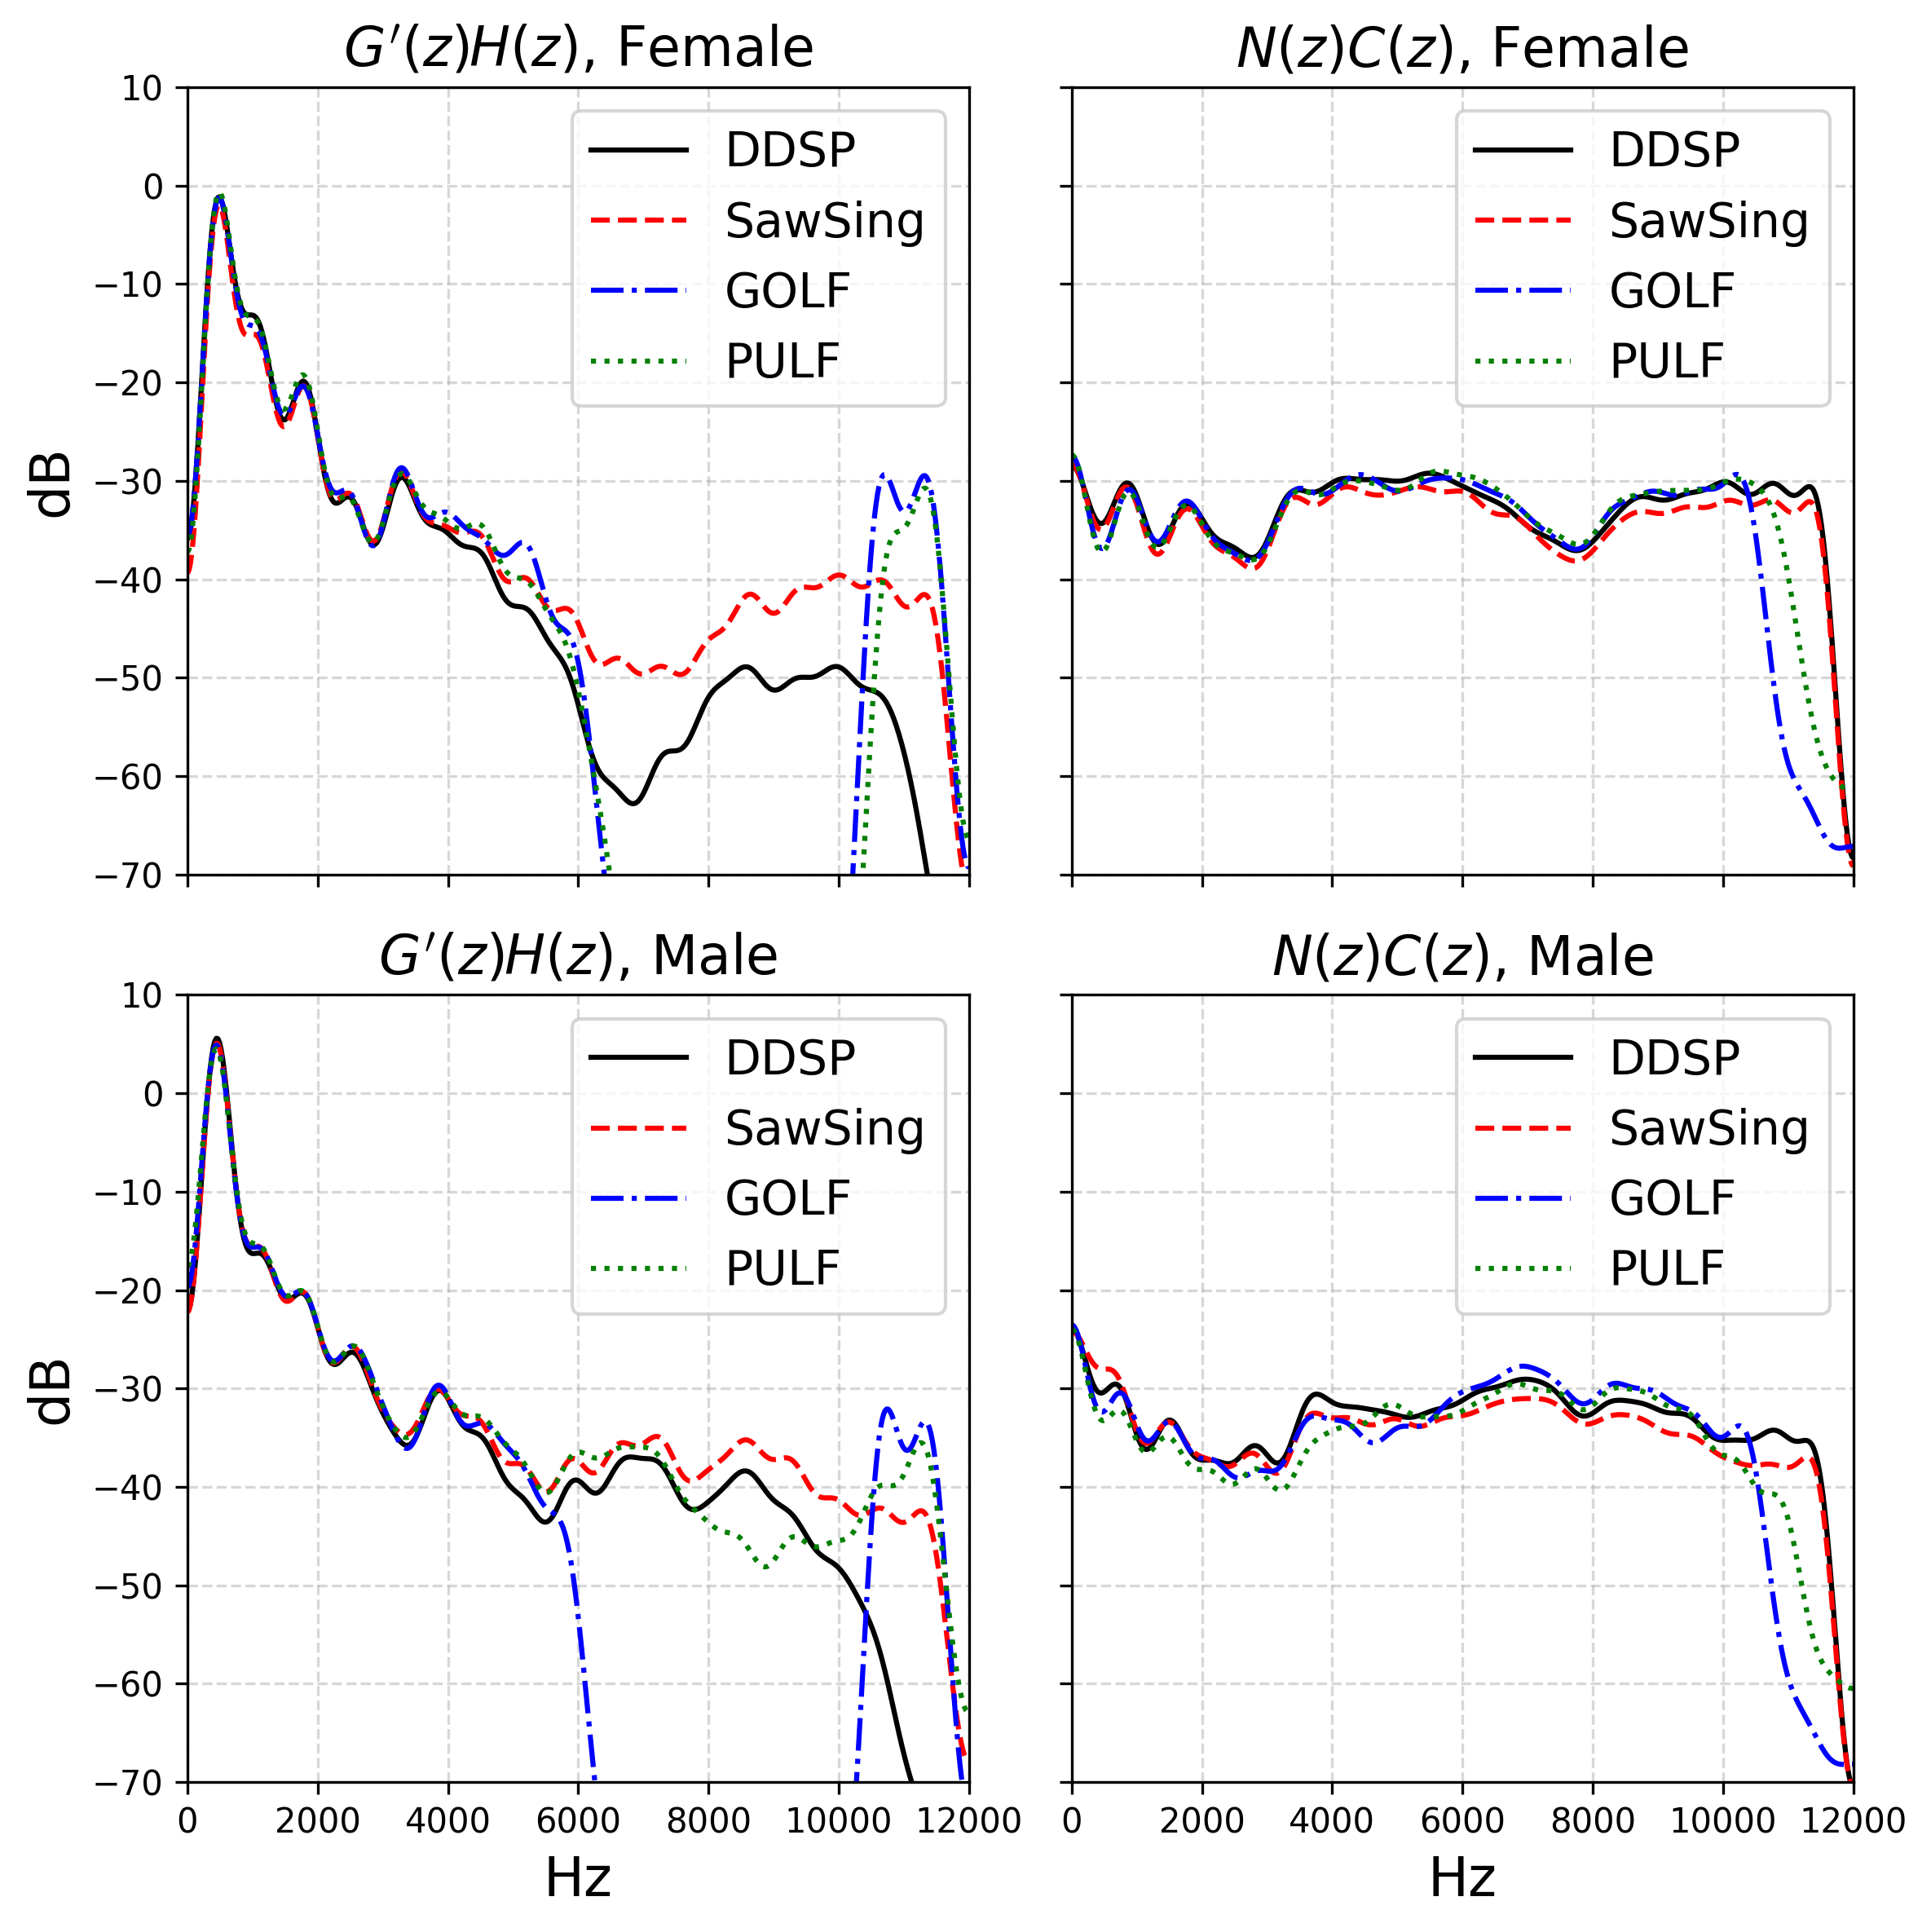

In [12]:
get_log_mean = lambda x: librosa.power_to_db(
    pysptk.mc2sp(pysptk.sp2mc(np.mean(x, axis=1) ** 2, 35, 0.0), 0.0, n_fft),
)

f1_mean_specs = {k: tuple(map(get_log_mean, v)) for k, v in f1_specs_dict.items()}
m1_mean_specs = {k: tuple(map(get_log_mean, v)) for k, v in m1_specs_dict.items()}

key2label = {"saw": "SawSing", "ddsp": "DDSP", "golf": "GOLF", "pulf": "PULF"}

freqs = librosa.fft_frequencies(sr=24000, n_fft=n_fft)

fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True, dpi=300)
plt.rc("axes", titlesize=16)
plt.rc("axes", labelsize=16)
# plt.rc('xtick', labelsize=14)
# plt.rc('ytick', labelsize=14)
ax[0, 0].set_title("$G'(z)H(z)$, Female")
ax[0, 1].set_title("$N(z)C(z)$, Female")
ax[1, 0].set_title("$G'(z)H(z)$, Male")
ax[1, 1].set_title("$N(z)C(z)$, Male")

ax[0, 0].set_ylabel("dB")
ax[1, 0].set_ylabel("dB")
ax[1, 0].set_xlabel("Hz")
ax[1, 1].set_xlabel("Hz")
ax[0, 0].set_ylim(-70, 10)
ax[0, 0].set_xlim(0, 12000)

for k, c, linestyle in zip(
    ["ddsp", "saw", "golf", "pulf"],
    ["black", "red", "blue", "green"],
    ["-", "--", "-.", ":"],
):
    f1_v = f1_mean_specs[k]
    m1_v = m1_mean_specs[k]
    ax[0, 0].plot(freqs, f1_v[0], label=key2label[k], color=c, linestyle=linestyle)
    ax[0, 1].plot(freqs, f1_v[1], label=key2label[k], color=c, linestyle=linestyle)
    ax[1, 0].plot(freqs, m1_v[0], label=key2label[k], color=c, linestyle=linestyle)
    ax[1, 1].plot(freqs, m1_v[1], label=key2label[k], color=c, linestyle=linestyle)


for a in ax.flatten():
    a.legend(fontsize=14)
    a.grid(linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [4]:
lowpass_idx = int(1024 * 6000 / 24000)
print(lowpass_idx)
correlation = lambda x, y: (lambda xx, yy: (xx @ yy) / np.sqrt(xx @ xx * yy @ yy))(
    x[:lowpass_idx].ravel(), y[:lowpass_idx].ravel()
)
f1_cosine = {k: 1 - correlation(*v) for k, v in f1_specs_dict.items()}
m1_cosine = {k: 1 - correlation(*v) for k, v in m1_specs_dict.items()}
print(f1_cosine)
print(m1_cosine)

256
{'golf': 0.9477465786039829, 'saw': 0.932918444275856, 'pulf': 0.9543818347156048, 'ddsp': 0.9451983235776424}
{'golf': 0.9367643222212791, 'saw': 0.8757160604000092, 'pulf': 0.941033910959959, 'ddsp': 0.9110564216971397}


## Analyse biquads

In [5]:
@torch.no_grad()
def a2z(a):
    a1 = a[..., 1]
    a2 = a[..., 2]
    half_a1 = a1 / 2
    sq = torch.sqrt((half_a1**2 - a2).cfloat())
    return torch.stack([-half_a1 - sq, -half_a1 + sq], dim=-1)


z2freq = lambda x, sr: torch.angle(x).abs() / torch.pi * sr * 0.5
R2B = lambda R, sr: -torch.log(R) * sr / torch.pi
pole2peak = lambda p: -20 * torch.log10(
    (1 - p.abs()) * torch.abs(1 - p.abs() * torch.exp(-1j * p.angle() * 2))
)

In [6]:
f1_folder = "tismir_tmp_audio/biquads/f1/"
m1_folder = "tismir_tmp_audio/biquads/m1/"


def process(x):
    z = a2z(x)
    freq = z2freq(z[..., 0], 24000)
    B = R2B(torch.abs(z[..., 0]), 24000)
    peak = pole2peak(z[..., 0])
    return freq, B, peak


def get_biquad_stats(state_dict, key, voice_only=False):
    cum_freq_mean = 0
    cum_freq_std = 0
    cum_peak_mean = 0
    cum_peak_std = 0
    N = 0
    valid_N = 0
    onepole_portion = 0
    for k in filter(lambda x: key in x, state_dict.keys()):
        v = state_dict[k]
        voicing = state_dict[k.replace(key, "voicing")].as_tensor()
        f, B, peak = process(v.as_tensor())
        voicing_mask = voicing > 0.5
        onepole_mask = (f < 1) | (f > 11999)
        if voice_only:
            N += voicing_mask.count_nonzero()
            onepole_portion += (onepole_mask & voicing_mask[..., None]).count_nonzero(
                (0, 1)
            )
            mask = voicing_mask.unsqueeze(-1) & ~onepole_mask
        else:
            N += voicing_mask.numel()
            onepole_portion += onepole_mask.count_nonzero((0, 1))
            mask = ~onepole_mask

        if mask.any():
            valid_N += mask.count_nonzero((0, 1))
            cum_freq_mean += (f * mask).sum((0, 1))
            cum_peak_mean += (peak * mask).sum((0, 1))

    cum_freq_mean /= valid_N
    cum_peak_mean /= valid_N

    for k in filter(lambda x: key in x, state_dict.keys()):
        v = state_dict[k]
        voicing = state_dict[k.replace(key, "voicing")].as_tensor()
        f, B, peak = process(v.as_tensor())
        voicing_mask = voicing > 0.5
        onepole_mask = (f < 1) | (f > 11999)
        if voice_only:
            mask = voicing_mask.unsqueeze(-1) & ~onepole_mask
        else:
            mask = ~onepole_mask
        if mask.any():
            cum_freq_std += (((f - cum_freq_mean) ** 2) * mask).sum((0, 1)) / valid_N
            cum_peak_std += (((peak - cum_peak_mean) ** 2) * mask).sum((0, 1)) / valid_N

    return {
        "freq_mean": cum_freq_mean,
        "freq_std": torch.sqrt(cum_freq_std),
        "peak_mean": cum_peak_mean,
        "peak_std": torch.sqrt(cum_peak_std),
        "onepole_portion": onepole_portion / N,
    }


f1_state_dicts = {x.stem: torch.load(x) for x in Path(f1_folder).rglob("*.pt")}
m1_state_dicts = {x.stem: torch.load(x) for x in Path(m1_folder).rglob("*.pt")}
f1_biquad_stats = {
    k: {
        sub_k: get_biquad_stats(v, sub_k, voice_only)
        for sub_k, voice_only in [("harm_biquads", True), ("noise_biquads", False)]
    }
    for k, v in f1_state_dicts.items()
}
m1_biquad_stats = {
    k: {
        sub_k: get_biquad_stats(v, sub_k, voice_only)
        for (sub_k, voice_only) in [
            ("harm_biquads", True),
            ("noise_biquads", False),
        ]
    }
    for k, v in m1_state_dicts.items()
}

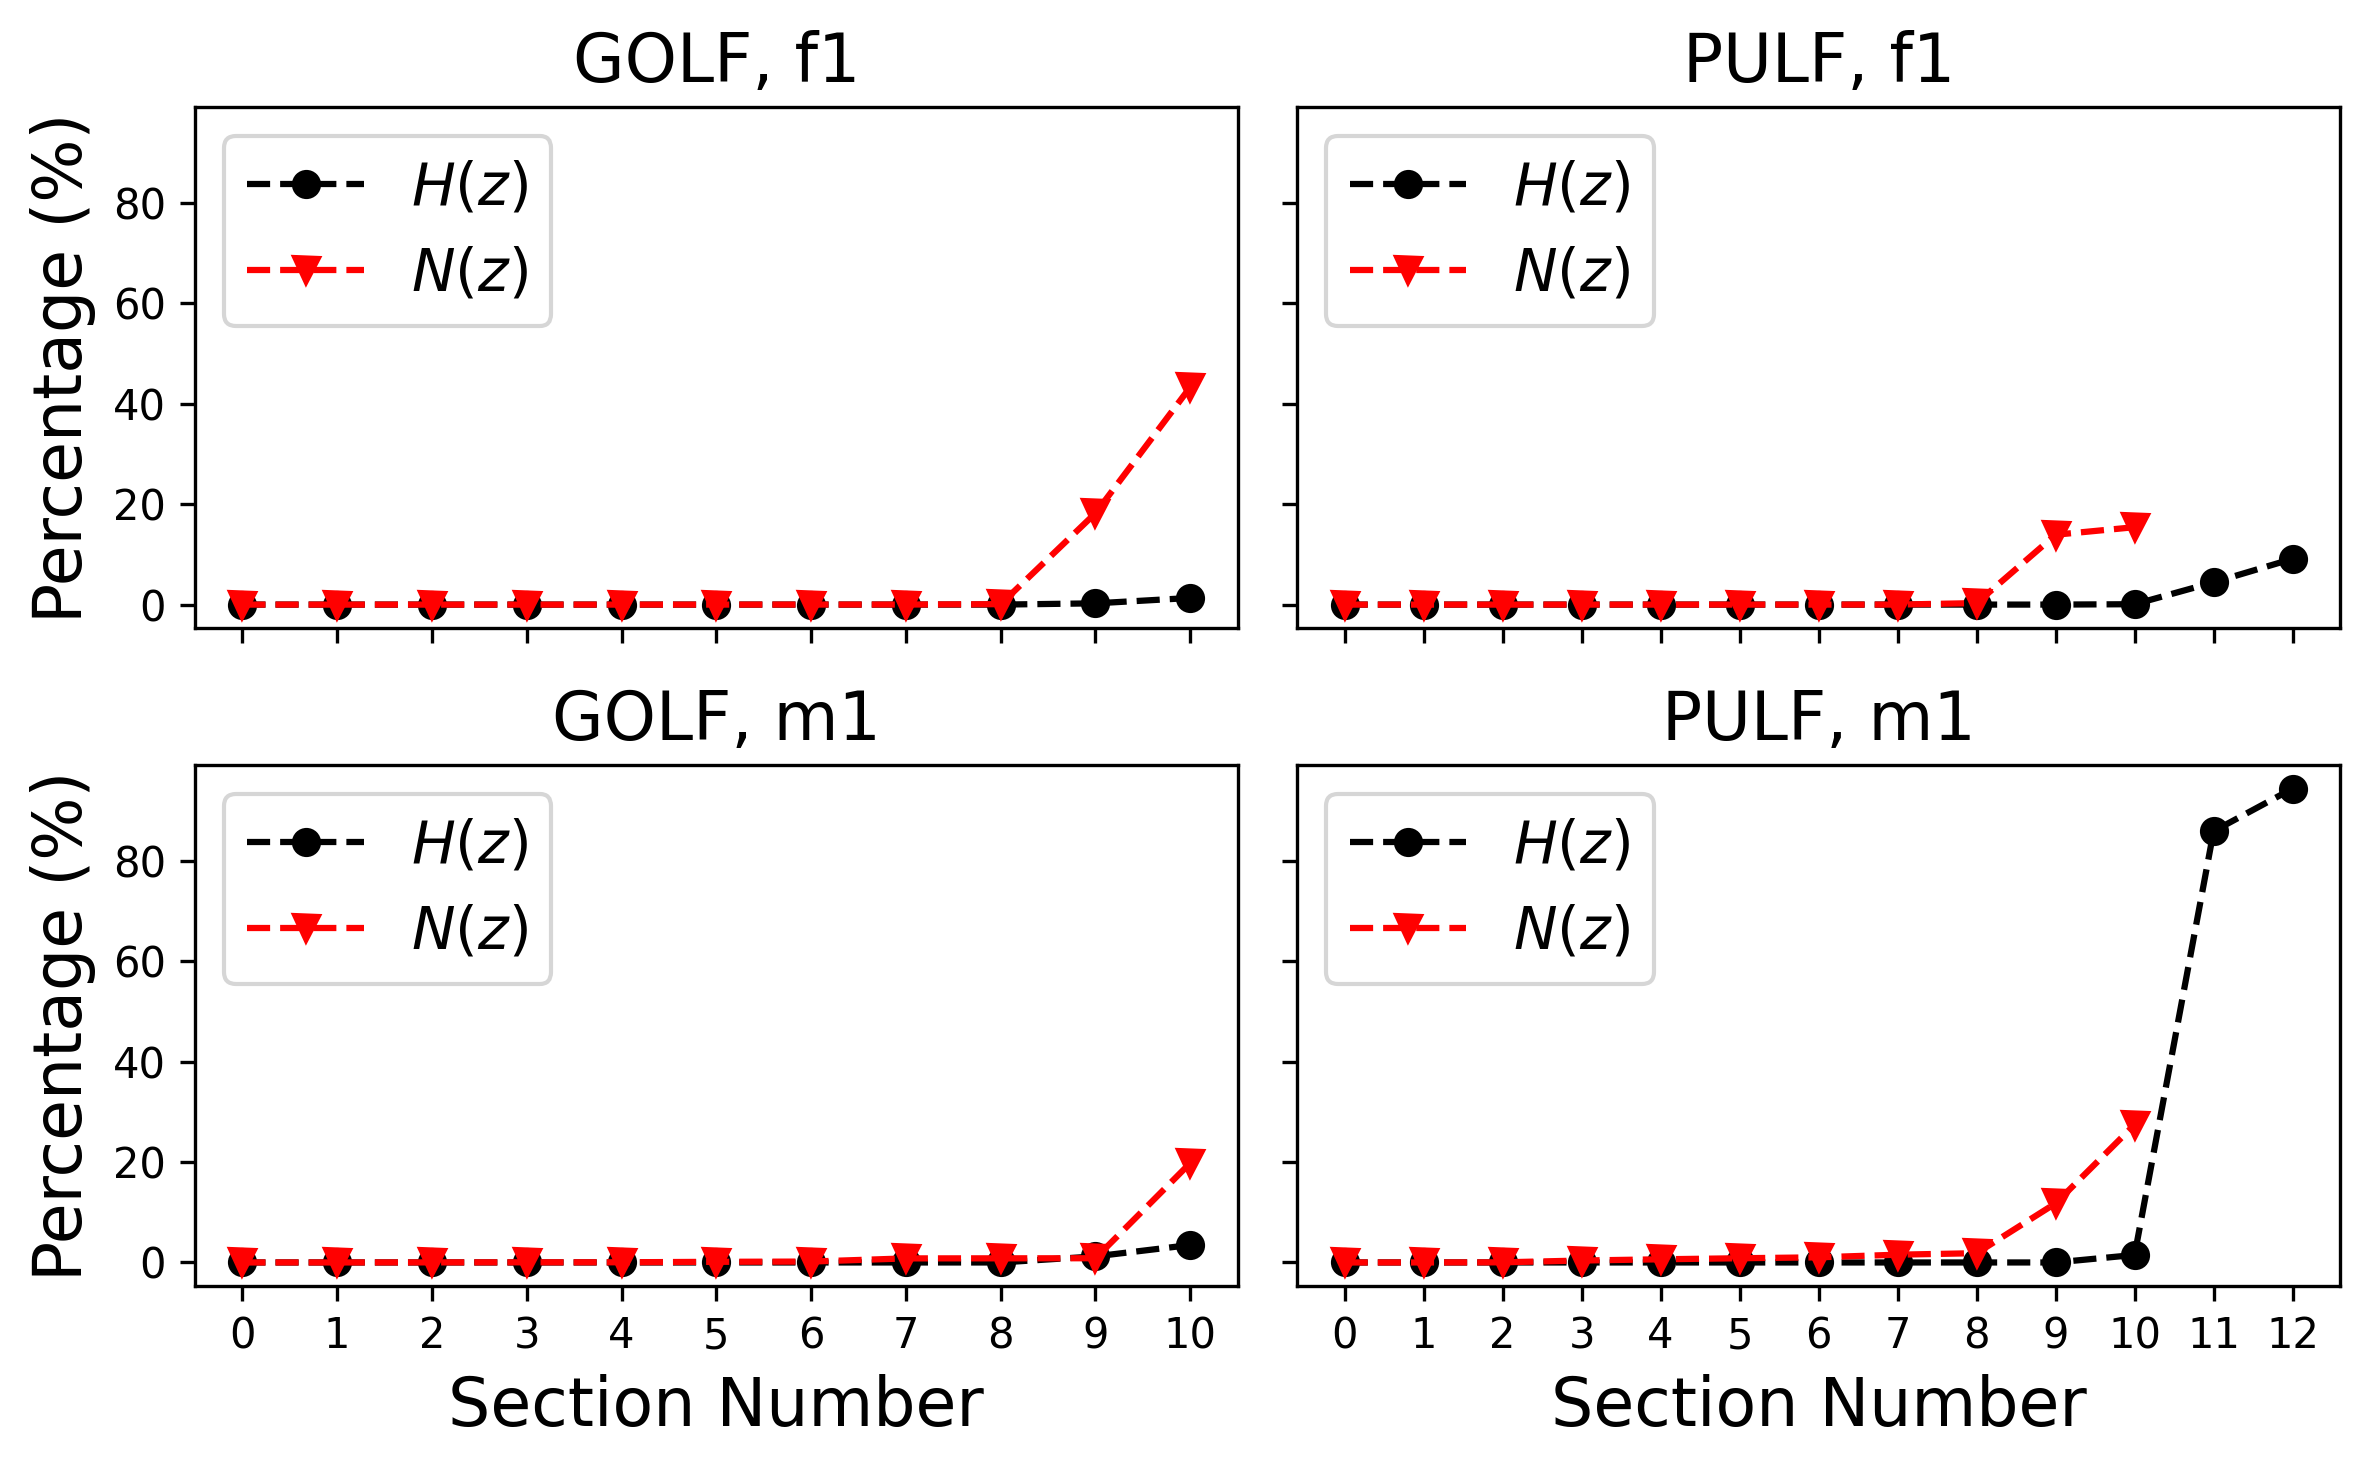

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5), sharex="col", sharey=True, dpi=300)
plt.rc("axes", titlesize=16)
plt.rc("axes", labelsize=16)

for i, (singer, s) in enumerate(zip(["f1", "m1"], [f1_biquad_stats, m1_biquad_stats])):
    for j, m in enumerate(["golf", "pulf"]):
        ax[i, j].set_title(f"{m.upper()}, {singer}")
        num_sections = 0
        for k, c, marker in zip(
            ["harm_biquads", "noise_biquads"], ["black", "red"], ["o", "v"]
        ):
            label = "$H(z)$" if "harm" in k else "$N(z)$"
            x = s[m][k]["onepole_portion"]
            x = x.sort().values * 100
            ax[i, j].plot(
                range(x.shape[0]),
                x.numpy(),
                label=label,
                color=c,
                marker=marker,
                linestyle="--",
            )
            num_sections = max(num_sections, x.shape[0])
            # plt.hist(s[m][k]["onepole_portion"].numpy() * 100, bins=[0, 1, 2, 5, 10, 20, 50, 100])
        ax[i, j].set_xticks(range(num_sections))
        ax[i, j].legend(fontsize=14, loc="upper left")

for i in range(2):
    ax[1, i].set_xlabel("Section Number")
    ax[i, 0].set_ylabel("Percentage (%)")

plt.tight_layout()
plt.show()

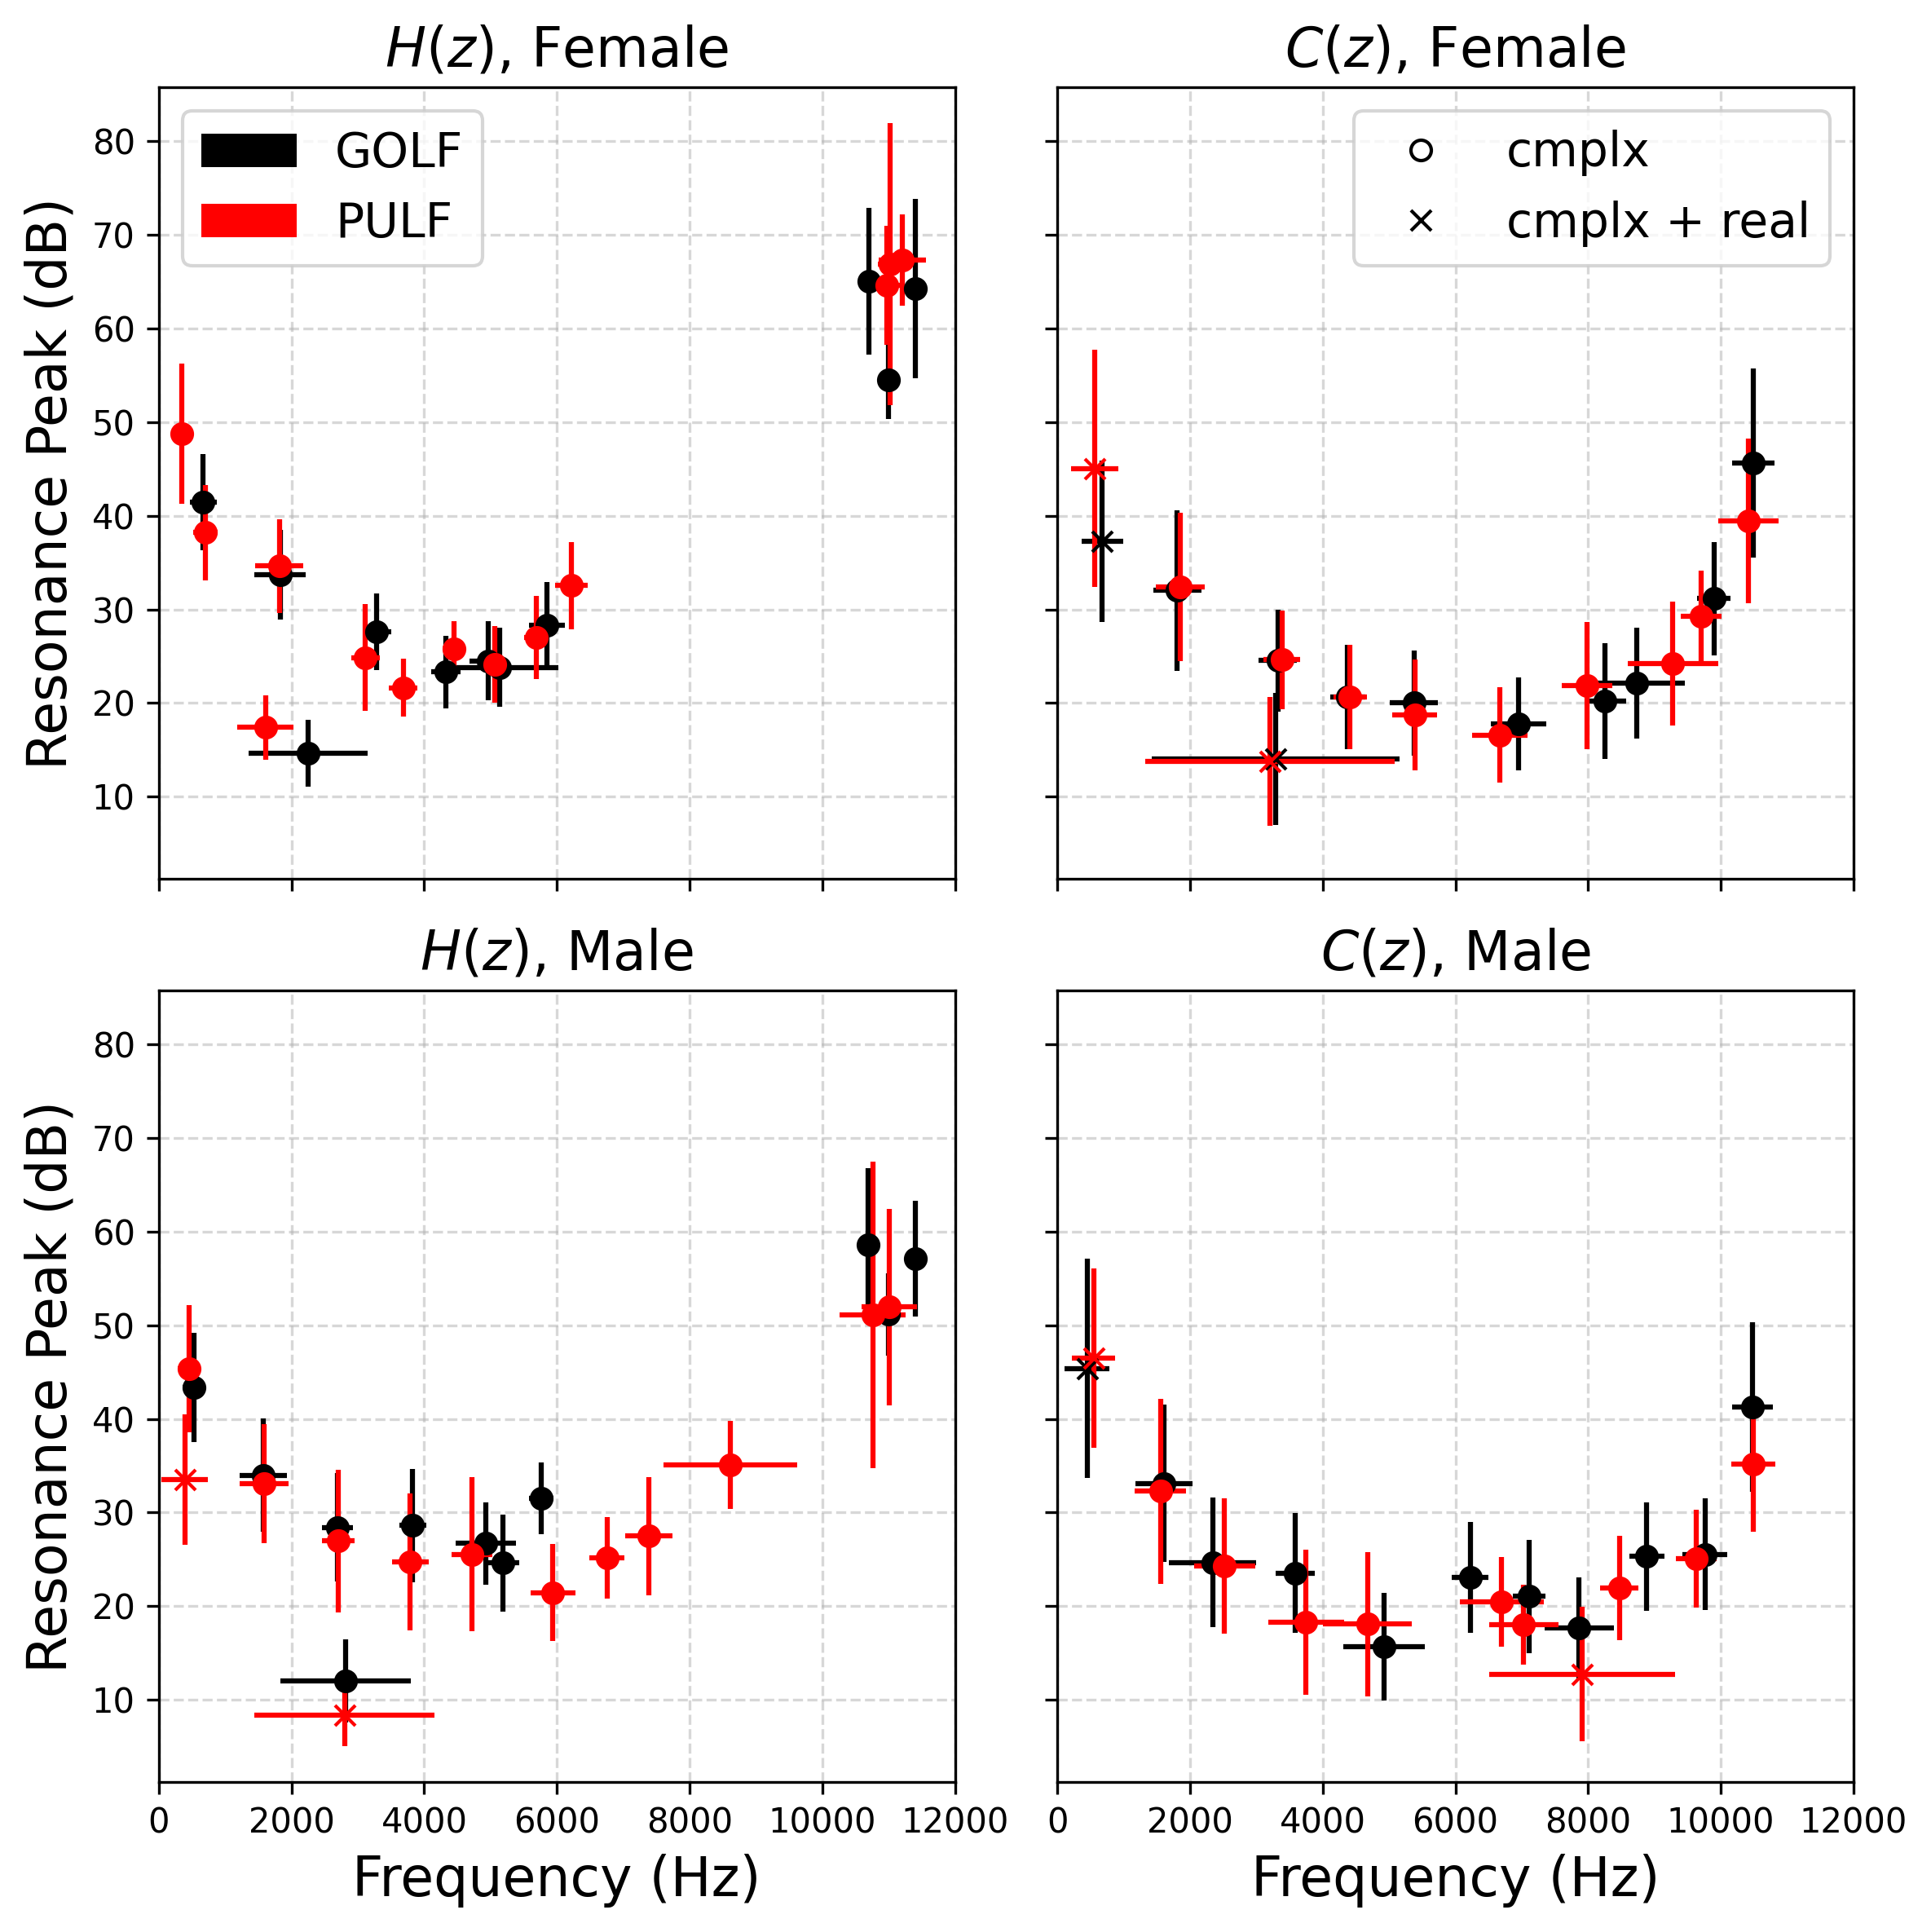

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), dpi=300, sharey=True, sharex=True)
plt.rc("axes", titlesize=16)
plt.rc("axes", labelsize=16)


def plot_function(ax, bqs, label, fmt, onepole_fmt, c):
    x, y, xerr, yerr = (
        bqs["freq_mean"],
        bqs["peak_mean"],
        bqs["freq_std"],
        bqs["peak_std"],
    )
    mask = bqs["onepole_portion"] < 0.1

    ax.errorbar(
        x[mask],
        y[mask],
        xerr=xerr[mask],
        yerr=yerr[mask],
        fmt=fmt,
        label=label + " (cmplx)",
        c=c,
    )

    if not mask.all():
        ax.errorbar(
            x[~mask],
            y[~mask],
            xerr=xerr[~mask],
            yerr=yerr[~mask],
            fmt=onepole_fmt,
            label=label + " (cmplx + real)",
            c=c,
        )
    return


ax[0, 0].set_title("$H(z)$, Female")
ax[0, 1].set_title("$C(z)$, Female")
ax[1, 0].set_title("$H(z)$, Male")
ax[1, 1].set_title("$C(z)$, Male")

settings = (
    {"label": "GOLF", "fmt": "o", "onepole_fmt": "x", "c": "black"},
    {"label": "PULF", "fmt": "o", "onepole_fmt": "x", "c": "r"},
)
for (ax_index, k), setting in product(
    zip(range(2), ["harm_biquads", "noise_biquads"]), settings
):
    label = setting["label"]
    plot_function(ax[0, ax_index], f1_biquad_stats[label.lower()][k], **setting)

for (ax_index, k), setting in product(
    zip(range(2), ["harm_biquads", "noise_biquads"]), settings
):
    label = setting["label"]
    plot_function(ax[1, ax_index], m1_biquad_stats[label.lower()][k], **setting)

for i in range(2):
    ax[1, i].set_xlabel("Frequency (Hz)")
for i in range(2):
    ax[i, 0].set_ylabel("Resonance Peak (dB)")

for i in range(2):
    for j in range(2):
        ax[i, j].grid(linestyle="--", alpha=0.5)
        # ax[i, j].legend(loc="upper left", fontsize=12)
ax[0, 0].set_xlim(0, 12000)

legend_shapes = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="cmplx",
        markerfacecolor="w",
        markeredgecolor="k",
    ),
    Line2D(
        [0],
        [0],
        marker="x",
        color="w",
        label="cmplx + real",
        markerfacecolor="w",
        markeredgecolor="k",
    ),
]
legend_colors = [
    Patch(facecolor="black", label="GOLF"),
    Patch(facecolor="red", label="PULF"),
]

ax[0, 1].legend(handles=legend_shapes, loc="upper right", fontsize=14)
ax[0, 0].legend(handles=legend_colors, loc="upper left", fontsize=14)

plt.tight_layout()
plt.show()

/var/folders/t1/lbply_210pldp5d77sl0cx3m0000gn/T/ipykernel_29346/1587772700.py:33: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


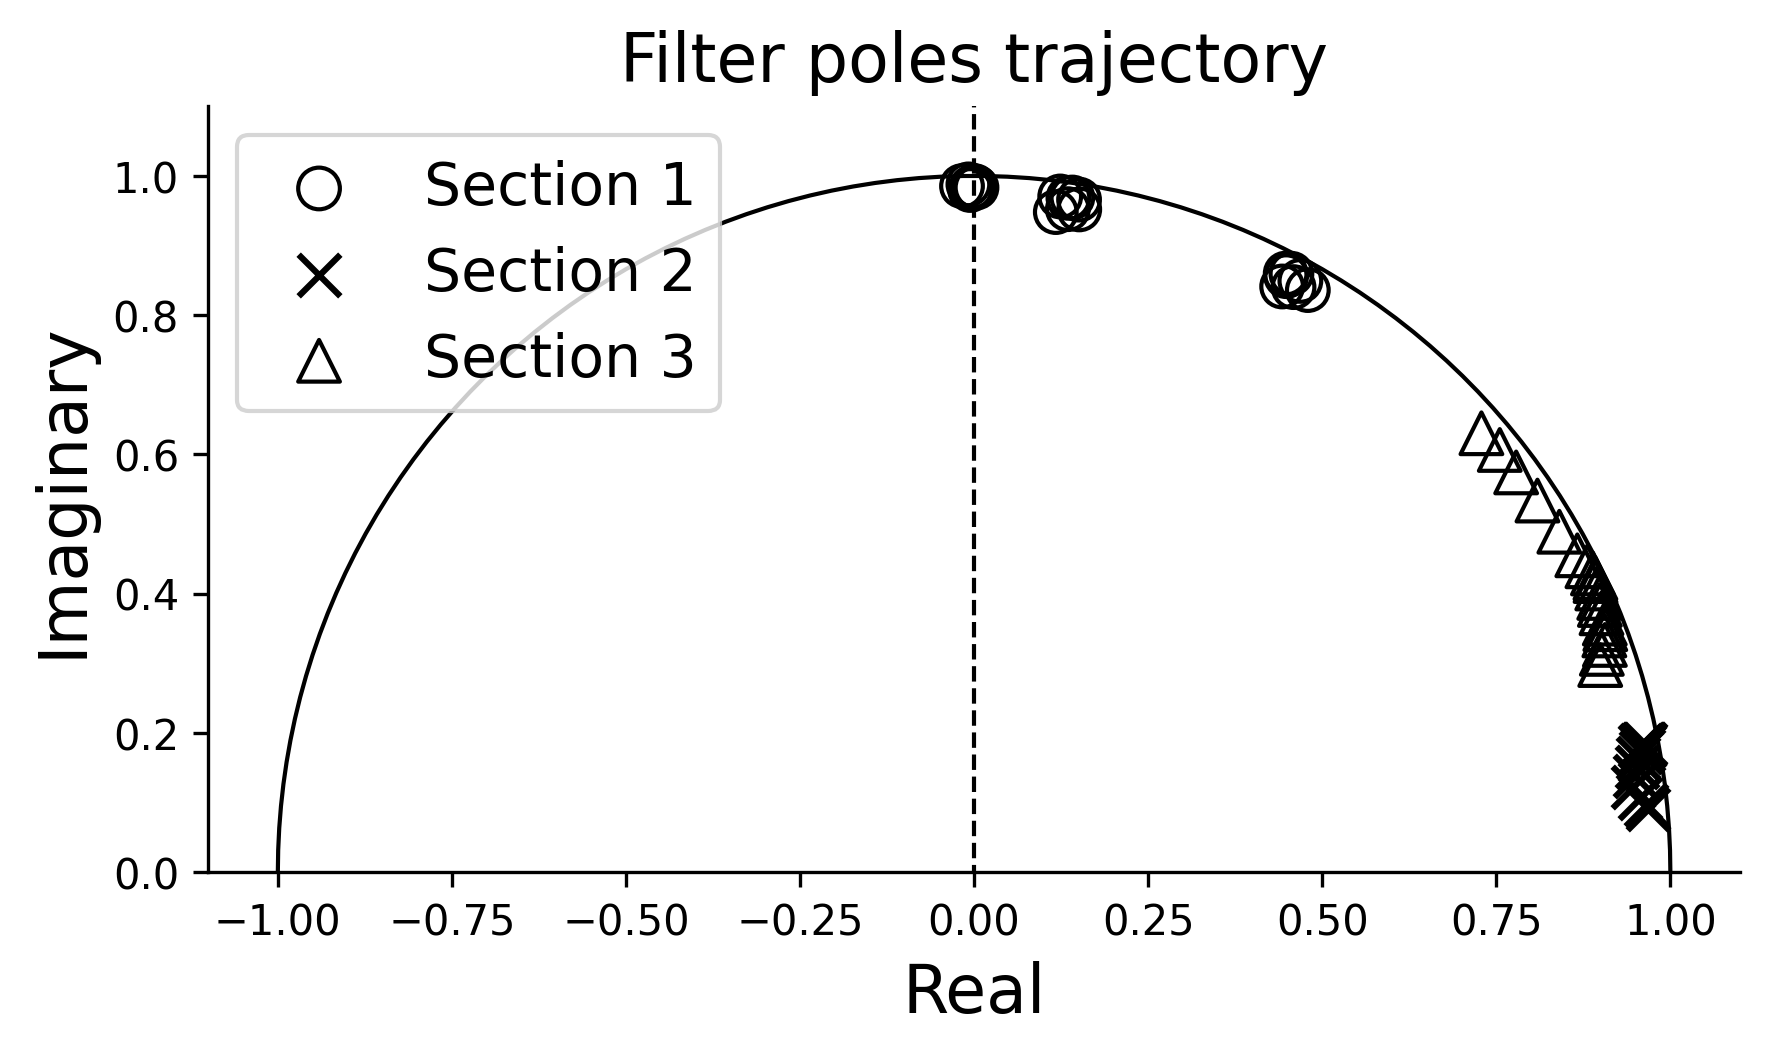

In [9]:
def half_unit_circle(ax):
    """
    Plots the unit circle on a given axis.
    """
    theta = np.linspace(0, 1 * np.pi, 100)
    x = np.cos(theta)
    y = np.sin(theta)
    ax.plot(x, y, color="black", linewidth=1)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_aspect("equal", adjustable="box")
    # ax.hlines(0, -1.2, 1.2, color="black", linestyle="--", linewidth=1)
    ax.vlines(0, -1.2, 1.2, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginary")
    # remove upper and right spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    return


segment_num = "001_0"
candidate_section_indexes = [1, 6, 9]

fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)
half_unit_circle(ax)

for i, (idx, mark) in enumerate(zip(candidate_section_indexes, ["o", "x", "^"])):
    a = f1_state_dicts["golf"][f"f1_{segment_num}.harm_biquads"]
    z = a2z(a[0, 530:550, idx])
    trajectory = torch.view_as_real(z.as_tensor()[:, 0]).numpy()
    # don't fill the color
    ax.scatter(
        trajectory[:, 0],
        np.abs(trajectory[:, 1]),
        label=f"Section {i+1}",
        marker=mark,
        edgecolors="black",
        facecolors="none" if mark != "x" else "black",
        s=100,
    )

plt.legend(loc="upper left", fontsize=14)
plt.title("Filter poles trajectory")
plt.tight_layout()
plt.show()

## Analyss $R_d$

In [10]:
def calculate_Rd_stats(state_dict, key):
    cum_Rd_mean = 0
    cum_Rd_std = 0
    N = 0
    min_Rd = math.inf
    max_Rd = -math.inf

    index2Rd = lambda x: (math.log(0.3) + x * (math.log(2.7) - math.log(0.3))).exp()

    for k in filter(lambda x: key in x, state_dict.keys()):
        Rd = index2Rd(state_dict[k])
        min_Rd = min(min_Rd, Rd.min().item())
        max_Rd = max(max_Rd, Rd.max().item())
        voicing = state_dict[k.replace(key, "voicing")]
        voicing = voicing.set_hop_length(Rd.hop_length)
        voicing_mask = voicing > 0.5
        N += voicing_mask.count_nonzero().as_tensor()
        cum_Rd_mean += (Rd * voicing_mask).as_tensor().sum()
    cum_Rd_mean /= N

    for k in filter(lambda x: key in x, state_dict.keys()):
        Rd = index2Rd(state_dict[k])
        voicing = state_dict[k.replace(key, "voicing")]
        voicing = voicing.set_hop_length(Rd.hop_length)
        voicing_mask = voicing > 0.5
        cum_Rd_std += (((Rd - cum_Rd_mean) ** 2) * voicing_mask).as_tensor().sum() / N

    return cum_Rd_mean.item(), torch.sqrt(cum_Rd_std).item(), min_Rd, max_Rd


f1_Rd_stats = calculate_Rd_stats(f1_state_dicts["golf"], "table_select_weight")
m1_Rd_stats = calculate_Rd_stats(m1_state_dicts["golf"], "table_select_weight")
print(f1_Rd_stats)
print(m1_Rd_stats)

(2.257094144821167, 0.40070247650146484, 1.0169841051101685, 2.6901702880859375)
(1.8285045623779297, 0.5447503924369812, 0.7096936702728271, 2.699528217315674)


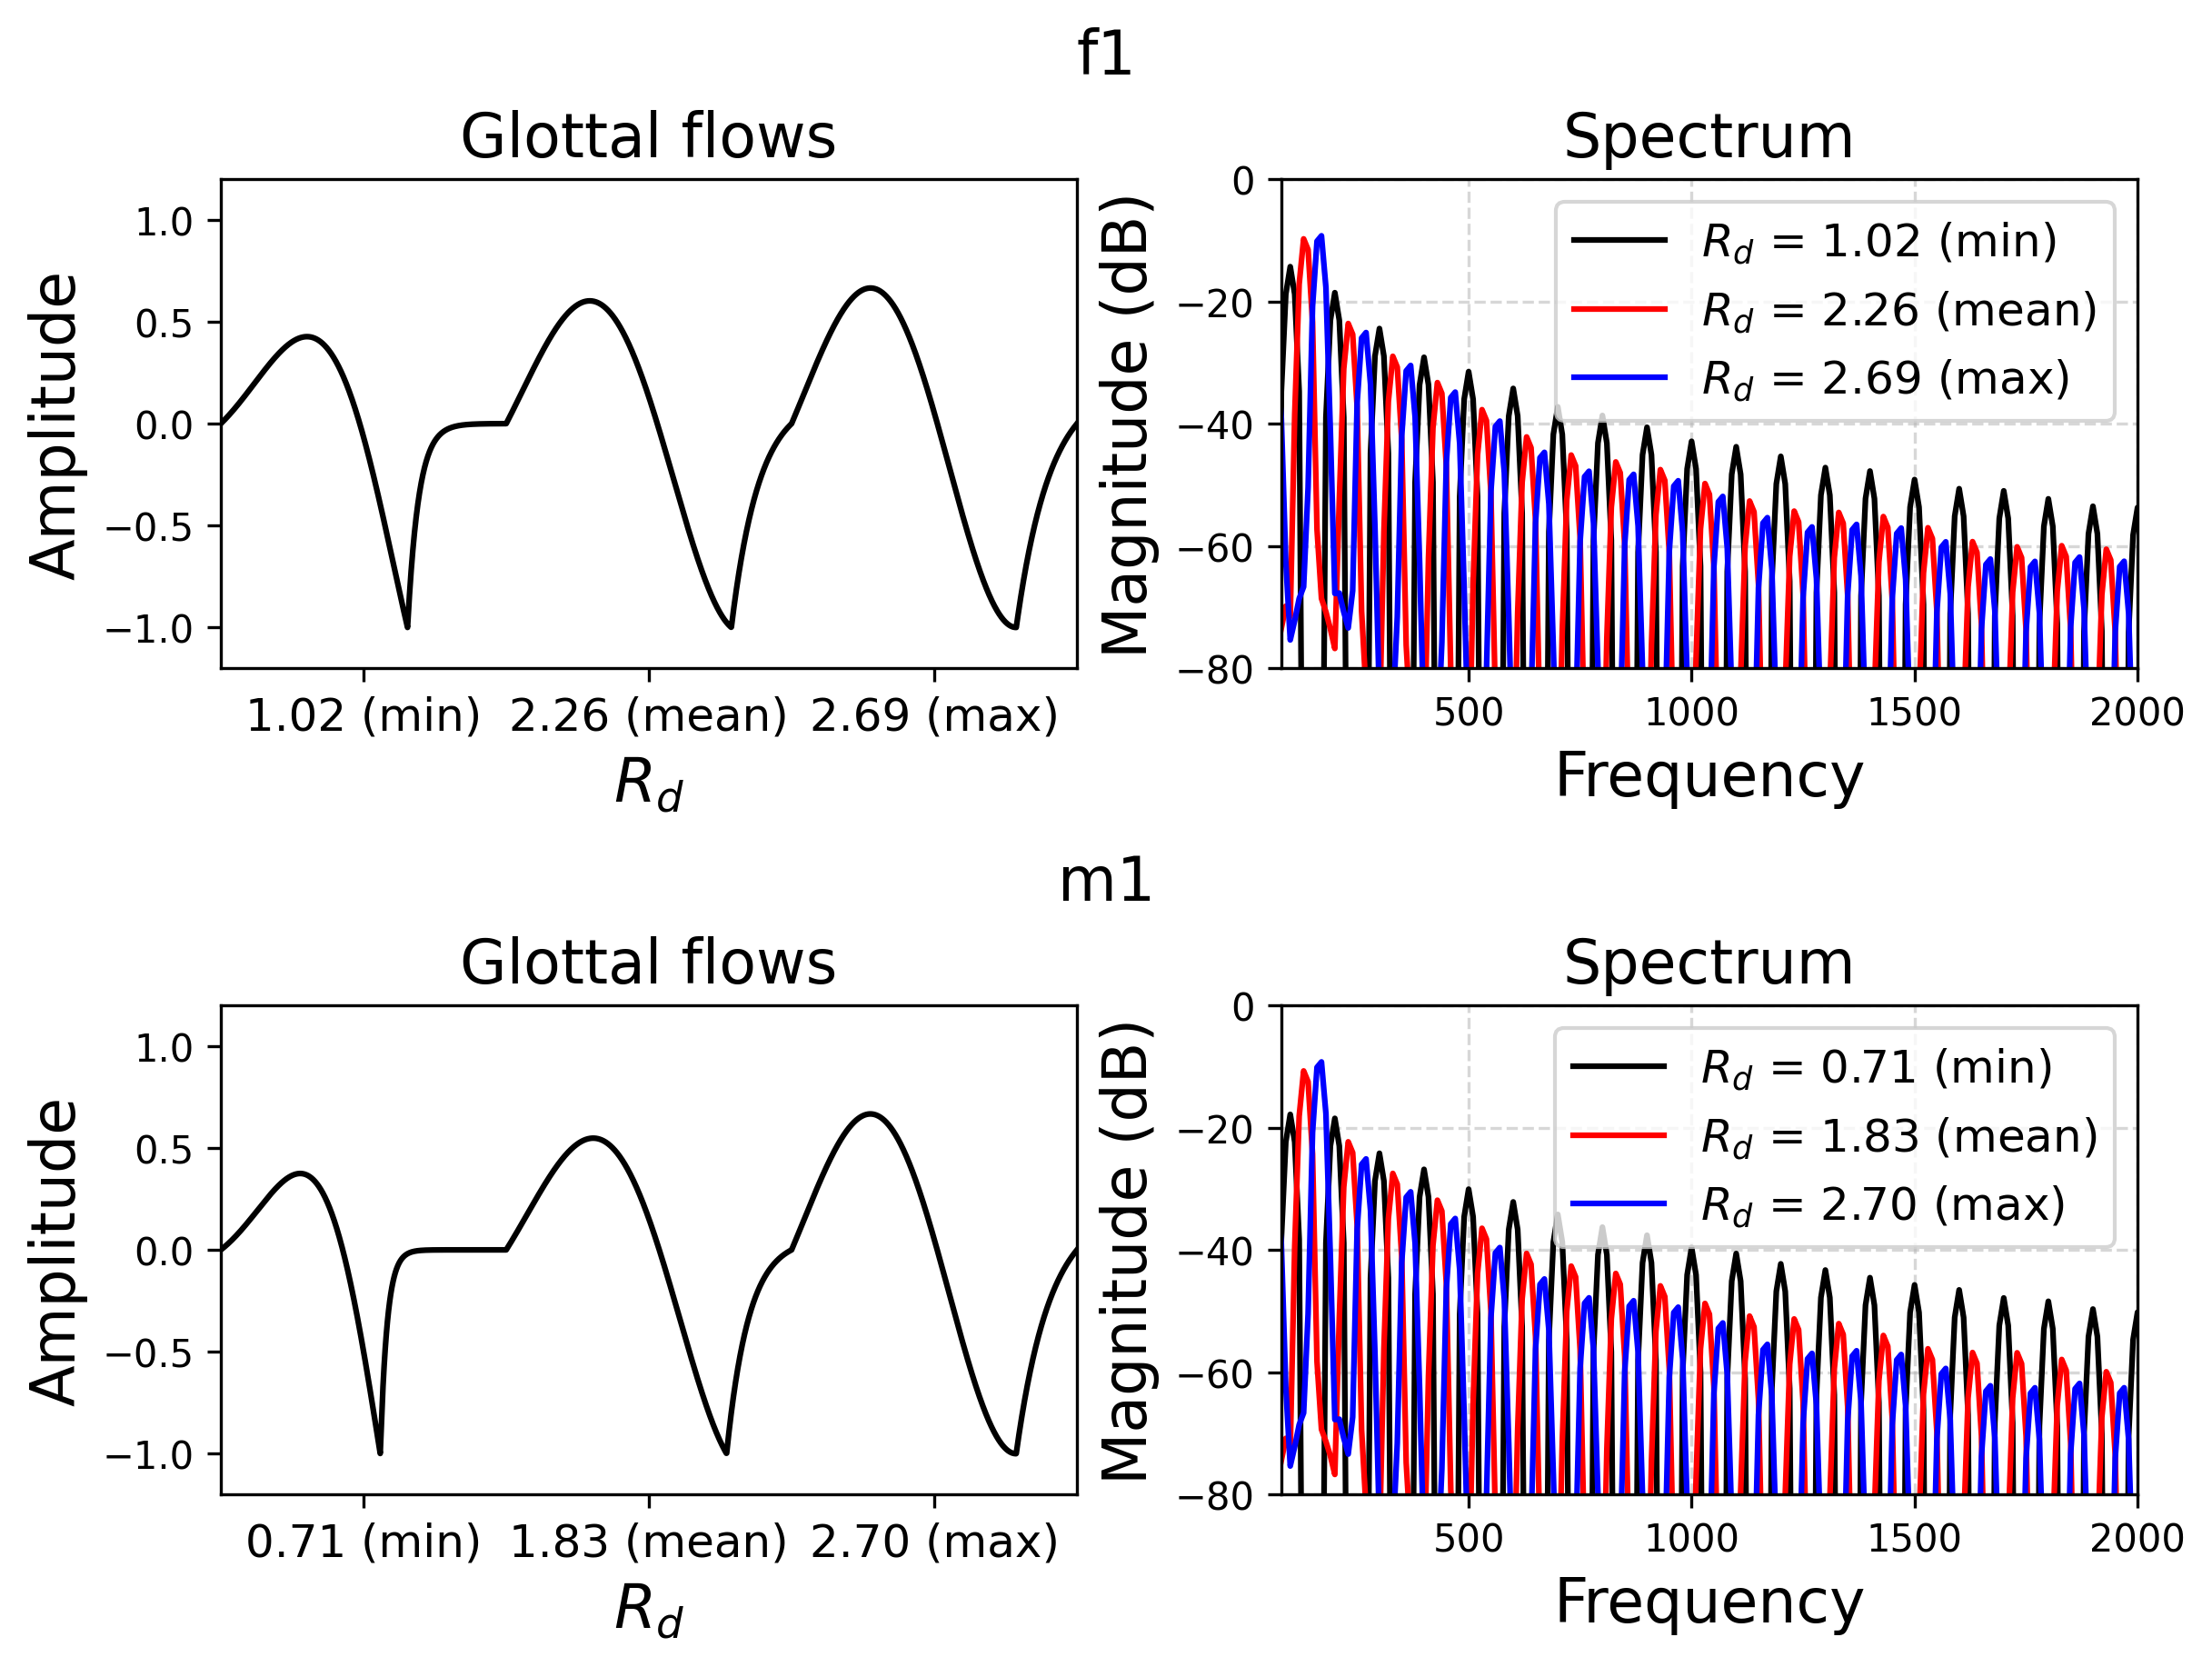

In [11]:
t = np.linspace(0, 1, 1024)
# plt.plot(t, get_transformed_lf_v2(f1_Rd_stats[0]))
# plot standard deviation

f1_flows = np.vstack(
    [
        get_transformed_lf_v2(x)
        for x in (
            # f1_Rd_stats[0] - f1_Rd_stats[1],
            f1_Rd_stats[2],
            f1_Rd_stats[0],
            f1_Rd_stats[3],
        )
    ]
)

f1_flows_repeat = np.tile(f1_flows, (1, 10))

m1_flows = np.vstack(
    [
        get_transformed_lf_v2(x)
        for x in (
            m1_Rd_stats[2],
            m1_Rd_stats[0],
            m1_Rd_stats[3],
        )
    ]
)
m1_flows_repeat = np.tile(m1_flows, (1, 10))


window = np.blackman(f1_flows_repeat.shape[1])

fig = plt.figure(figsize=(8, 6), dpi=300, layout="constrained")
subfigs = fig.subfigures(nrows=2, ncols=1)
# plt.rc("xtick", labelsize=10)

for singer, flows, repeat_flows, subfig, Rd_stats in zip(
    ["f1", "m1"],
    [f1_flows, m1_flows],
    [f1_flows_repeat, m1_flows_repeat],
    subfigs,
    [f1_Rd_stats, m1_Rd_stats],
):
    subfig.suptitle(f"{singer}", fontsize=16)
    ax = subfig.subplots(1, 2)
    ax[0].plot(flows.ravel(), color="black")
    ax[0].set_title(f"Glottal flows")
    ax[0].set_ylabel("Amplitude")
    ax[0].set_xlabel("$R_d$")
    ax[0].set_xticks(512 + np.arange(3) * 1024)
    ax[0].set_xticklabels(
        [
            f"{Rd_stats[2]:.2f} (min)",
            f"{Rd_stats[0]:.2f} (mean)",
            f"{Rd_stats[3]:.2f} (max)",
        ]
    )
    ax[0].set_xlim(0, 3072)
    ax[0].set_ylim(-1.2, 1.2)
    ax[0].tick_params(axis="x", labelsize=12)

    ax[1].magnitude_spectrum(
        repeat_flows[0],
        102400,
        color="black",
        scale="dB",
        window=window,
        label=f"$R_d$ = {Rd_stats[2]:.2f} (min)",
    )
    # multiply the signal with a complex sinusoid to shift the spectrum
    # shift 33 Hz
    ax[1].magnitude_spectrum(
        repeat_flows[1] * np.exp(1j * 2 * np.pi * 33 * np.arange(10240) / 102400),
        102400,
        color="red",
        scale="dB",
        window=window,
        label=f"$R_d$ = {Rd_stats[0]:.2f} (mean)",
    )
    # shift 66 Hz
    ax[1].magnitude_spectrum(
        repeat_flows[2] * np.exp(1j * 2 * np.pi * 66 * np.arange(10240) / 102400),
        102400,
        color="blue",
        scale="dB",
        window=window,
        label=f"$R_d$ = {Rd_stats[3]:.2f} (max)",
    )
    ax[1].set_xlim(80, 2000)
    ax[1].set_ylim(-80, 0)
    ax[1].legend(fontsize=12)
    ax[1].set_title("Spectrum")
    ax[1].grid(linestyle="--", alpha=0.5)


plt.show()